In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)

In [1]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import os
import torch.nn.functional as F

#plots
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.ticker as ticker

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


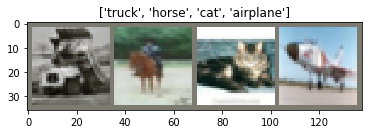

In [2]:
#LOAD DATA
batch_size=4
trainloader, testloader, attributes=data_loader.load_cifar10(batch_size)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
classes=attributes["class_names"]

# VISUALIZE
inputs, class_data = next(iter(trainloader))
visualize.imshow(inputs, title=[classes[i] for i in class_data])

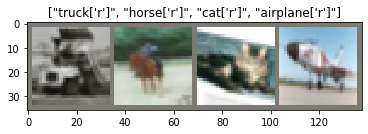

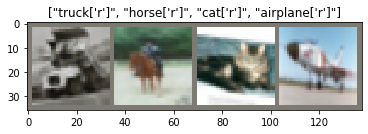

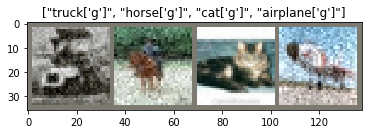

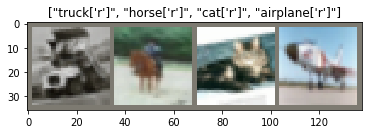

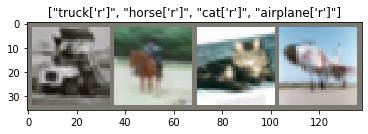

In [3]:
# TEST AUGMENTATION OF BATCH
aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs, n = 5, depth = 1, augmentations="r,g")
for i, _ in enumerate(aug_seqs_names):
    visualize.imshow(aug_batches[i], title=[classes[j]+str(aug_seqs_names[i]) for j in class_data])
    plt.pause(0.001)
    
# pause a bit so that plots are updated

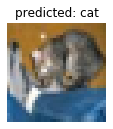

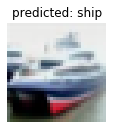

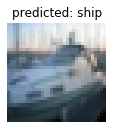

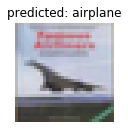

In [4]:
#load the pretrained resnet 18
model = resnet.resnet18(pretrained=True).to(device)
#train if necessary
#model_ft = train_model.train(model, trainloader, testloader,num_epochs=2, batch_size=batch_size)

path="cifar10_models/state_dicts/resnet18.pt"
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=4)

## FGSM

In [10]:
def plot_reliability(predicted_probs, real_labels, title = "Realiability plot"):
    import seaborn as sns
    sns.set("paper")
    buckets = list(np.linspace(0,1,11))
    probabilities = np.array([])  # this is the predicted confidence
    predicted_labels = np.array([]) 
    correct_labels = np.array([])
    for i,probs in enumerate(predicted_probs):
        probabilities = np.hstack((probabilities, probs.max(1,keepdim=True)[0].exp().squeeze().numpy()))
        predicted_labels = np.hstack((predicted_labels, probs.max(1,keepdim=True)[1].squeeze().numpy()))
        correct_labels = np.hstack((correct_labels, real_labels[i].cpu().numpy()))
    
    correct_labels
    bin_index = np.digitize(probabilities, buckets)-1
    
    accuracy = np.zeros((len(buckets)-1, 1))
    confidence = np.zeros((len(buckets)-1, 1))
    size_bins = np.zeros((len(buckets)-1, 1))
    
    for i, prob in enumerate(probabilities):
        size_bins[bin_index[i]] += 1
        confidence[bin_index[i]] += prob
        if predicted_labels[i] == correct_labels[i]:
            accuracy[bin_index[i]] += 1
    
    accuracy = accuracy/size_bins
    confidence = confidence/size_bins
    straight_line = [0,1]
    
    plt.figure(figsize=(7,7))
    plt.title(title)
    plt.plot(confidence, accuracy)
    plt.plot(straight_line, straight_line)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")

In [6]:
final_acc_b, adv_examples_b, predicted_probs_b, real_labels_b = FGSM.test(model, test_loader=testloader, epsilon=0)

Epsilon: 0	Test Accuracy = 9348 / 10000 = 0.9348


/home/samuele/anaconda3/envs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/samuele/anaconda3/envs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


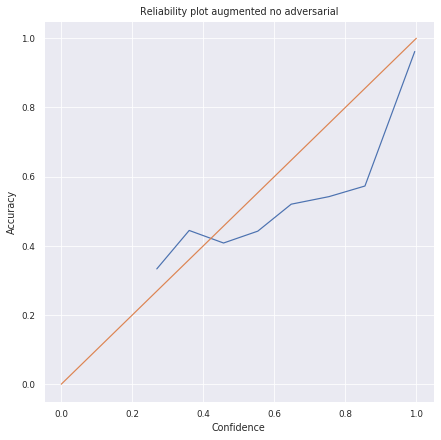

In [11]:
plot_reliability(predicted_probs_b, real_labels_b, title="Reliability plot augmented no adversarial")

In [5]:
final_acc_b, adv_examples_b = FGSM.test(model, test_loader=testloader, epsilon=0.3)

Epsilon: 0.3	Test Accuracy = 2928 / 10000 = 0.2928


In [5]:
final_acc_aug, adv_examples_aug, predicted_probs_aug, real_labels_aug = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "all", n = 21, v = 1)


25%
50%
75%
100%
Epsilon: 0	Test Accuracy = 9330 / 10000 = 0.933


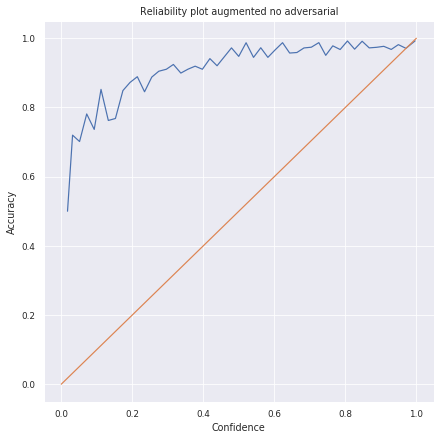

In [56]:
plot_reliability(predicted_probs_aug, real_labels_aug, title="Reliability plot augmented no adversarial")

In [7]:
final_acc_aug_adv, adv_examples_aug_adv, predicted_probs_aug_adv, real_labels_aug_adv = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "all", n = 21, v = 1)

25%
50%
75%
100%
Epsilon: 0.3	Test Accuracy = 3410 / 10000 = 0.341


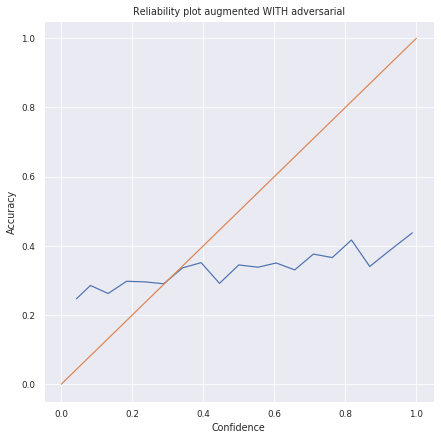

In [54]:
plot_reliability(predicted_probs_aug_adv, real_labels_aug_adv, title="Reliability plot augmented WITH adversarial")

In [6]:
final_acc_aug_adv, adv_examples_aug_adv, predicted_probs_aug_adv, real_labels_aug_adv = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "r", n = 21, v = 1)

Epsilon: 0	Test Accuracy = 7809 / 10000 = 0.7809


In [7]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "r", n = 5)

Epsilon: 0.3	Test Accuracy = 3846 / 10000 = 0.3846


In [10]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "all", n = 5)

Epsilon: 0.3	Test Accuracy = 3238 / 10000 = 0.3238


In [9]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0.3, augmentations = "all", n = 11)

Epsilon: 0.3	Test Accuracy = 3283 / 10000 = 0.3283


In [11]:
final_acc_aug, adv_examples_aug = FGSM.test_augmented(model, testloader, epsilon=0, augmentations = "r", n = 5)

Epsilon: 0	Test Accuracy = 9047 / 10000 = 0.9047


# FID

In [5]:
# calculate frechet inception distance
def calculate_fid(image1, image2):
    # calculate mean and covariance statistics
    mu1, sigma1 = image1.mean(axis=0), np.cov(image1, rowvar=False)
    mu2, sigma2 = image2.mean(axis=0), np.cov(image2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [6]:
def getFeatures(model):
    modules=list(model.children())[:-1]
    model_feature=nn.Sequential(*modules)
    for p in model_feature.parameters():
        p.requires_grad = False
    return model_feature, p

In [12]:
def getFID(feature_input, augmentation="g", noise_level=[0,10,20,30], n_input = 4):
    feature_input=model_features(inputs.to(device))
    feature_input_num=feature_input.cpu().detach().numpy().reshape(n_input,512)
    FID=[]
    plot_batch=[]
    for i in noise_level:
        aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs, augmentations=augmentation, n = 1, depth = 2, noise=(i,i), rot=(i,i))
        plot_batch.append(aug_batches[0][0])
        aug_features=model_features(aug_batches[0].to(device))
        aug_features_num=aug_features.cpu().detach().numpy().reshape(n_input,-1)
        FID.append(calculate_fid(feature_input_num, aug_features_num))
    plot_batch = torch.cat(plot_batch).reshape(n_input,3,32,32)
    return FID, plot_batch

In [8]:
def plot_fid(fid, plot_batch, ylim=150, xy = [1.5, 130], x_labels=[0,1,2,3]):
    _, ax = plt.subplots()
    inp = torchvision.utils.make_grid(plot_batch)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    imagebox = OffsetImage(inp, zoom=2)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, xy,
                        xybox=(0, 0),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0,
                        )

    ax.add_artist(ab)

    ax.set_xticks([0,1,2,3]) 
    ax.set_xticklabels(x_labels, fontsize=12)
    ax.set_ylabel("FID")
    ax.set_xlabel("Noise")
    ax.set_ylim(0, ylim)
    ax.plot(FID,marker='*')

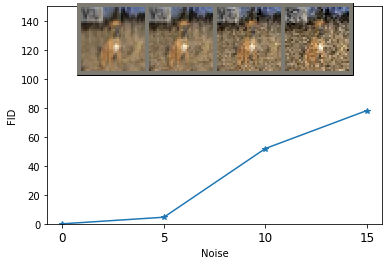

In [126]:
model_features, p = getFeatures(model)
FID, plot_batch = getFID(feature_input, augmentation="g", noise_level=[0,5,10,15])
plot_fid(FID, plot_batch, ylim=150, xy = [1.5, 150*0.85], x_labels=[0,5,10,15])

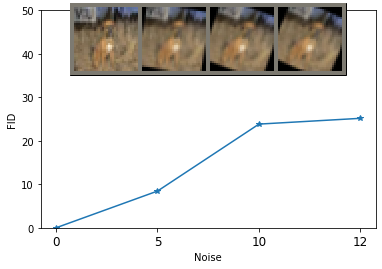

In [125]:
model_features, p = getFeatures(model)
FID, plot_batch = getFID(feature_input, augmentation="r", noise_level=[0,5,10,12])
plot_fid(FID, plot_batch, ylim=50, xy = [1.5, 50*0.87], x_labels=[0,5,10,12])

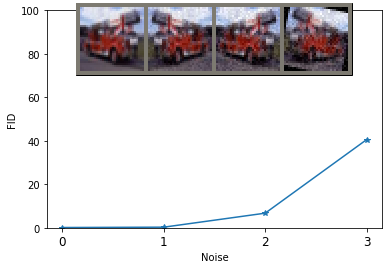

In [21]:
model_features, p = getFeatures(model)
FID, plot_batch = getFID(model_features, augmentation="all", noise_level=[0,5,10,12])
plot_fid(FID, plot_batch, ylim=100, xy = [1.5, 100*0.87])